In [2]:
from main import main
from PDconfig import LaVoz
from archivosDF import *

main()
ruta_barrios = './DataFrames/LaVoz/barrios.csv'
ruta_ciudades = './DataFrames/LaVoz/ciudades.csv'
df = abrirDF(LaVoz)

In [3]:
# Completar datos:
filt = df["terrenoEdificado"].isna() & df["tipoPropiedad"] == "DEPARTAMENTO"
df.loc[filt, "terrenoEdificado"] = df.loc[filt, "terrenoTotal"]
df.tipoPropiedad.value_counts()

tipoPropiedad
CASA                  13503
DEPARTAMENTO          10817
TERRENOS LOTES         5450
LOCAL                   776
OFICINAS                511
GALPONES DEPOSITOS      390
FONDO COMERCIO           52
COCHERAS                 34
Name: count, dtype: int64

In [4]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# CAMBIAR TIPOS PROP
reemplazos = {
  "DUPLEX" : "CASA",
  "DÚPLEX" : "CASA",
  "TRIPLEX" : "CASA",
  "CHALET" : "CASA", 
  "PREFABRICADA": "CASA", 
  "CABAÑA" : "CASA",
  "SEMIPISO" : "DEPARTAMENTO",
  "PISO" : "DEPARTAMENTO",
  "PENTHOUSE" : "DEPARTAMENTO",
  "LOFT" : "DEPARTAMENTO"
}
df["tipoPropiedad"].replace(reemplazos, inplace= True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENOS LOTES")
df = df.loc[filt]

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS LOTES"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS LOTES"]

In [5]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.01179), 
                                          inmuebles["terrenoTotal"].quantile(0.992))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.01179), 
                                          inmuebles["precioUSD"].quantile(0.992))

inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

# FILTRADO DETALLADO TERRENOS
filtro_TT = terrenos["terrenoTotal"].between(terrenos["terrenoTotal"].quantile(0.025), 
                                          terrenos["terrenoTotal"].quantile(0.99))
filtro_P = terrenos["precioUSD"].between(terrenos["precioUSD"].quantile(0.025), 
                                          terrenos["precioUSD"].quantile(0.99))

terrenos_filt = terrenos.loc[filtro_TT & filtro_P]

In [68]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
std_costo_barrio = g_barrios['precioUSD'].std().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_barrio = g_barrios['precio_m2_total'].std().round(0)
std_costo_m2_edif_barrio = g_barrios['precio_m2_edif'].std().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'STD Costo' : std_costo_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'STD $/m2 Total' : std_costo_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'STD $/m2 Edif' : std_costo_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

In [69]:
# Step 5: Group the data by 'ciudad' only (excluding barrio)
g_ciudad = inmuebles_filt[inmuebles_filt['barrio'].isnull()].groupby('ciudad')

# Step 6: Calculate the average house cost for each group (excluding barrio)
costo_prom_ciudad = g_ciudad['precioUSD'].mean().round(0)
std_costo_ciudad = g_ciudad['precioUSD'].std().round(0)
costo_med_ciudad = g_ciudad['precioUSD'].median().round(0)

# Step 7: Calculate the cost per square meter ($/m2) for each group (excluding barrio)
costo_prom_m2_tot_ciudad = g_ciudad['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_ciudad = g_ciudad['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_ciudad = g_ciudad['precio_m2_total'].std().round(0)
std_costo_m2_edif_ciudad = g_ciudad['precio_m2_edif'].std().round(0)

costo_med_m2_tot_ciudad = g_ciudad['precio_m2_total'].median().round(0)
costo_med_m2_edif_ciudad = g_ciudad['precio_m2_edif'].median().round(0)

# Step 8: Count the number of houses being sold in each group (excluding barrio)
inmuebles_por_ciudad = g_ciudad.size()

# Merge the results for city-level statistics
resultados_ciudad = pd.DataFrame({
    'Costo Prom': costo_prom_ciudad,
    'STD Costo' : std_costo_ciudad,
    'Costo Med': costo_med_ciudad,
    'Prom $/m2 Total': costo_prom_m2_tot_ciudad,
    'STD $/m2 Total' : std_costo_m2_tot_ciudad,
    'Med $/m2 Total': costo_med_m2_tot_ciudad,
    'Prom $/m2 Edif': costo_prom_m2_edif_ciudad,
    'STD $/m2 Edif' : std_costo_m2_edif_ciudad,
    'Med $/m2 Edif': costo_med_m2_edif_ciudad,
    'Cant': inmuebles_por_ciudad
}).reset_index()

In [70]:
guardarDF(resultados_barrio, ruta_barrios)
guardarDF(resultados_ciudad, ruta_ciudades)

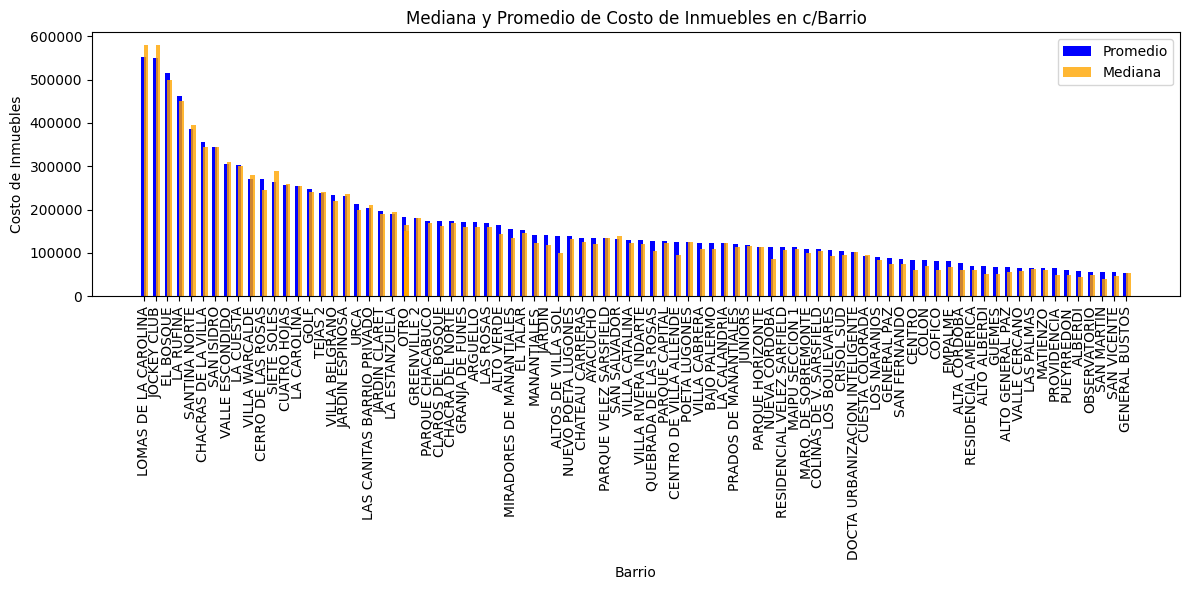

In [76]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 38]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


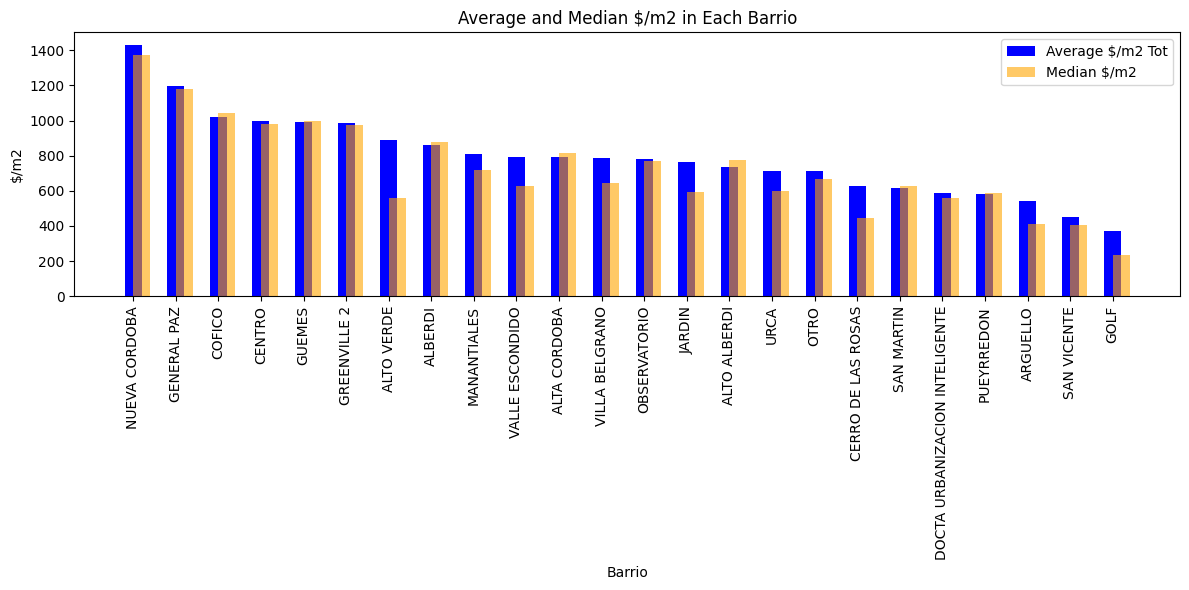

In [66]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'Costo Prom' in descending order to get the highest-cost barrios at the top
resultados_barrio_sorted = resultados_barrio.sort_values(by='Prom $/m2 Total', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 100]

# Plot the distribution of average house cost and median for all barrios
plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, resultados_barrio_sorted['Prom $/m2 Total'], width=bar_width, label='Average $/m2 Tot', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados_barrio_sorted['Med $/m2 Total'], width=bar_width, label='Median $/m2', color='orange', alpha=0.6, align='edge')


plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Average and Median $/m2 in Each Barrio')
plt.legend()
plt.tight_layout()
plt.show()
